**Authors:**  Yonatan Tarazona <br>
**Email:** geoyons@gmail.com <br>
**Copyright:** Yonatan Tarazona 2022<br>
**License:** MIT

# **_<div class="alert alert-success"><font color='darkred'> Detecting forest disturbances using Sentinel-1 through a non-seasonal detection approach based on time series</font></div>_**

The following topics will be covered:

 1. [Introduction](#section1)
 2. [Study area](#section2)
 3. [Data and methods](#section3)
    - [Prerequisites like libraries]() 
    - [Brief introduction to the PVts-$\beta$ approach]() 
    - [Detect changes in order to map deforestation]()
        - [Using radar imagery]()
 4. [Pross and cons about detecting deforestation in time series domain](#section4)

### Learning outcomes

At the end of this notebook you will know:

* How to use radar images (Sentinel-1) to map deforestation using Google Earth Engine and Python
* How to use a non-seasonal detection approach based on time series to map forest disturbances.
* How to visualise brakpoints in time series.
* Pros and cons about detecting vegetation changes with time series instead of machine learning or deep learning.

So, let's start!

<img src="https://raw.githubusercontent.com/ytarazona/mappingForestDisturbances/main/data/amazon.jpg" align="center" width="1000"/>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Introduction

</div>

Monitoring vegetation dynamics, which includes forest disturbances such as deforestation, through Remote Sensing is widely preferred over in-situ processes for several reasons: (i) Remote Sensing allows monitoring large extensions from local, regional and global scales, (ii) the cost is minimal, considering that large satellite image databases of different spatial resolutions exist with free access for different applications, and (iii) because Remote Sensing data adhere to the principles of repeatability, objectivity and consistency, which are prerequisites in the framework of monitoring and surveillance of natural resources. Vegetation change detection is addressed by different approaches ranging from the use of artificial intelligence and its algorithms supervised classification of Machine Learning or Deep Learning, or based on Time Series through vegetation indices or fractions indices. These latter methods are subdivided into seasonal and non-seasonal approaches, where the former make strong use of the seasonal component of Time Series to model and detect changes, while non-seasonal approaches do not rely on the seasonal component and given their simplicity are implemented in languages such as Python and R, but not yet in Google Earth Engine (GEE).

In this tutorial you will learn how to detect deforestion using a non-seasonal detection approach (PVts-$\beta$) based on time series using GEE with Python API. To follow this tutorial, vegetation indices, fraction indices and radar polarizations such as Normalized Difference Vegetation Index (NDVI), Enhanced Vegetation Index (EVI), Normalized Difference Fraction Index (NDFI) and VH, VV, HV, HH can be used. Here, VH polarization of Sentinel-1 will be be used in order to map deforestation.

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Study area

</div>

The study area for this tutorial is located in Madre de Dios, an Amazon region in the southeast of Peru. This region is a hotspot of great biodiversity and carbon sequestration. However, deforestation based mainly on logging, agriculture, and gold mining, is endangering forest ecosystem services and having negative effects on the surrounding population and the Peruvian state. In fact, deforestation is increasing in recent years.

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Data and methods

</div>

###  3.1 Prerequisites like libraries

**Step 1**: A few Earth Engine and Python libraries will be used in order to detect deforestation.

**Earth engine library**

Run the following cell to initialize the Python API. It is necessary to have an [account](https://earthengine.google.com/) in GEE to get started. 

In [1]:
import ee
# Trigger the authentication flow
ee.Authenticate()
# Initialize the library
ee.Initialize()

**Python libraries**

If you are using either Anaconda or [Google Colaboraty](https://colab.research.google.com/?utm_source=scs-index), there are two packages that it is necessary to install, ```geemap``` and ```forestools```. Their installations are simple, run just these lines:

```python
# forestools
!pip install git+https://github.com/ytarazona/forestools

# geemap
!pip install git+https://github.com/giswqs/geemap
```

Please see the documentation for more details:

- [geemap](https://github.com/ytarazona/forestools).
- [forestools](https://github.com/giswqs/geemap/).

In addition, there are another python libraries to be used. These packages will be useful for plotting some results.

In [2]:
import matplotlib.pyplot as plt
from forestools.pvts import pvts
from forestools.plot import plot
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In order to have interactive results, the *geemap* package will be imported, so just run these lines:

In [3]:
import geemap as emap
import geemap.colormaps as cm
Map = emap.Map()
Map.add_basemap('SATELLITE')

### 3.2 Introduction to the PVts-$\beta$ approach

Time series methods for mapping deforestation are generally classified into seasonal and non-seasonal approaches. Seasonal approaches are widely used and a variety of algorithms exist, but all of them are highly dependent on the seasonal component of the time series. The non-seasonal detection approach (i.e. PVts-$\beta$ approach proposed by [Tarazona et al. (2018)](https://doi.org/10.1016/j.ecolind.2018.07.012), does not depend on seasonality and could be the best option in order to map forest disturbances, for instance deforestation.

In order to detect deforestation with this approach, it is necessary to obtain: (i) the time in which a deforestation event will be detected, i.e., the temporal position $n$ of the pixel $P_{i,j}$:

$$P_{i,j} = s_{1} + s_{2} + s_{3} + \ldots + s_{n-1} + s_{n}$$

(ii) the mean ($\mu_{i,j}$) and its standard deviation ($\sigma_{i,j}$) for the same pixel $s_{i,j}$ (from $s_{1}$ to $s_{n-1}$). If the value for position ($n$) is less than the established limit (${L_{i,j}}^{n-1}$):

$${L_{i,j}}^{n-1} = \mu_{i,j} - \beta *\sigma_{i,j}$$

then a disturbance is detected in the forest (e.g., deforestation).

where, ${L_{i,j}}^{n-1}$ is the lower limit, $\beta$ is the threshold magnitude, and $i,j$ is the row and column position of a given pixel.

The only parameter to obtain is the $\beta$ value. This parameter was calibrated with NDVI and EVI in the work of [Tarazona et al. (2018)](https://doi.org/10.1016/j.ecolind.2018.07.012), for NDFI indices in the work of [Tarazona (2021)](10.1109/LGRS.2021.3137277). So that, courtesy of them, we can visualize the optimal $\beta$ values for different indices. Pandas and matplotlib libraries will be used for the purpose of elaborating these interesting figures:

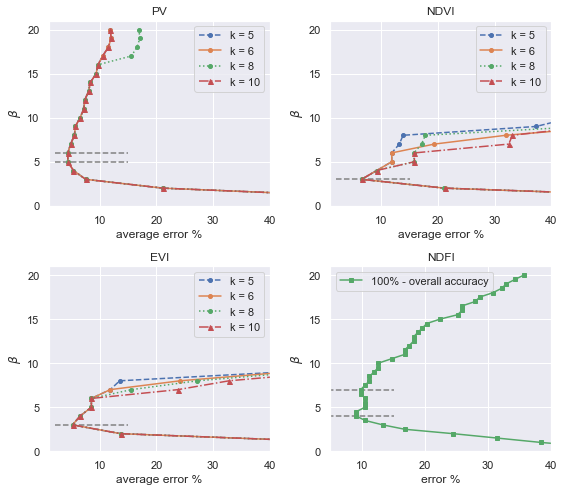

In [4]:
# courtesy of Tarazona et al. (2018)
url1 = "https://github.com/ytarazona/ft_data/raw/main/data/data_cv_beta_tarazonaetal2018.csv"
data_2018 = pd.read_csv(url1, index_col = 0, sep = ";")

# courtesy of Tarazona et al. (2022)
url2 = "https://github.com/ytarazona/ft_data/raw/main/data/data_cal_beta_tarazona2022.csv"
data_2022 = pd.read_csv(url2, index_col = 0, sep = ";")

# y - axis
y = np.arange(1, 21)
i = [0, 1, 2, 3]
style = ['--','-',':','-.']
mark = ['.', '.', '.', '^']
size = [8, 8, 8, 5]
cross_validation = ['k = 5', 'k = 6', 'k = 8', 'k = 10']

fig, axes = plt.subplots(2,2, figsize = (8, 7))
# PV serie
for i,st, m, s, cv  in zip(i, style, mark, size, cross_validation):
    axes[0][0].plot(data_2018.iloc[:,i], y, linestyle = st, marker = m, ms = s, label = cv)
axes[0][0].hlines([5, 6], 2, 15, 'gray', '--')
axes[0][0].set(title = 'PV', xlabel = 'average error %', ylabel = r'$\beta$', xlim = (1, 40), ylim=(0, 21))
axes[0][0].legend()

# NDVI serie
i = [4, 5, 6, 7]
for i,st, m, s, cv  in zip(i, style, mark, size, cross_validation):
    axes[0][1].plot(data_2018.iloc[:,i], y, linestyle = st, marker = m, ms = s, label = cv)
axes[0][1].hlines([3], 2, 15, 'gray', '--')
axes[0][1].set(title = 'NDVI', xlabel = 'average error %', ylabel = r'$\beta$', xlim = (1, 40), ylim=(0, 21))
axes[0][1].legend()

# EVI serie
i = [8, 9, 10, 11]
for i,st, m, s, cv  in zip(i, style, mark, size, cross_validation):
    axes[1][0].plot(data_2018.iloc[:,i], y, linestyle = st, marker = m, ms = s, label = cv)
axes[1][0].hlines([3], 2, 15, 'gray', '--')
axes[1][0].set(title = 'EVI', xlabel = 'average error %', ylabel = r'$\beta$', xlim = (1, 40), ylim=(0, 21))
axes[1][0].legend()

# NDFI serie
axes[1][1].plot(100-data_2022.iloc[:,0]*100, np.arange(0.5, 20.5, 0.5), 
                'g-', marker = 's', ms = 4, label = '100% - overall accuracy')
axes[1][1].hlines([4, 7], 2, 15, 'gray', '--')
axes[1][1].set(title = 'NDFI', xlabel = 'error %', ylabel = r'$\beta$', xlim = (5, 40), ylim=(0, 21))
axes[1][1].legend()
fig.tight_layout()
plt.show()

Although, there are reference values for $\beta$, it should be noted that this can be modified according to the needs of cartographic accuracy or the study region. Consider reading the articles cited lines above.

*Here are some examples of change detection using a non-seasonal approach. Panel (a) is a change by agriculture and panel (b) is a change by gold mining activity*.

<img src="https://raw.githubusercontent.com/ytarazona/mappingForestDisturbances/main/data/examples_detections.jpg" align="center" width="750"/>

On ther other hand, this detection approach was implemented in both [Python](https://github.com/ytarazona/forestools) and [R](https://github.com/ytarazona/ForesToolboxRS) packages, so that if you are not familiar with Earth Engine's architecture, you have different alternatives to apply a non-seasonal detection approach. *Try to do it*.

### 3.3 Detect changes in order to map deforestation

### Using radar imagery

Sentinel-1 is a C-band Synthetic Aperture Radar that supports a wide variety of applications, including deforestation assessment. For this tutorial VH polarization acquired in Interferometric Wide Swath mode and in Ground Range Detected (GRD) format was used. In GEE, the pre processing of Calibration and terrain correction were made. The VH radar backscattering coefficients ($\sigma0$) is obtained in decibels ($dB$). But, remember to convert from digital number (DN) values to $dB$ is with:

$${dB}_{i,j}=10\ast{log}_{10}({{DN}_{i,j}}^2/A^2)$$

where, $i$, $j$ represents the position (row and column), and $A$ represents the calibration factor, which can be looked up in the *sigma naught* values in the lookup table (LUT).

> For this tutorial, no filter was applied to remove the speckle noise. This step was not necessary in order to avoid losing spatial resolution. Nevertheless, it is a free option!.  

**Step 2**: *Collection of Sentinel-1 was used*:

In [4]:
# Area of interes
roi = ee.Geometry.Rectangle([-70.734, -13.167, -69.727, -12.552])

# Load Sentinel-1 C-band SAR Ground Range Detected (log scale, VH, descending)
collectionS1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
                 .filter(ee.Filter.eq('instrumentMode', 'IW'))\
                 .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
                 .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
                 .filterMetadata('resolution_meters', 'equals' , 10)\
                 .filterBounds(roi)

When we are detecting changes using time series, it is usually to separate in a time-serie reference and a target year. The reference serie is for calculating the mean ($\mu_{i,j}$) and standard deviation ($\sigma_{i,j}$), while the target year is the year in which the changes will be detected.

**Step 3**: *Let's separate in a time-serie reference and a target year*

In this step we will separete a time-series *reference* and the *target year*. The target year will be used to detect deforestation. Here, deforestation will be detected from 2018-2021 (four years)


In [5]:
# ---------------------------------- Important!---------------------------

# 1. Reference -> '2016-01-01', '2017-12-31'
collr = collectionS1.filterDate('2016-01-01', '2017-12-31')

# 2. Selecting polarization
collVHr = collr.select('VH')

# 2. Image target used to detect deforestation
# Deforestation will be detected from 2018-2021 (four years)
# So, let´s take an image in 2021.
imgTar = collectionS1.filterDate('2021-12-01', '2021-12-20').select("VH")\
               .reduce(ee.Reducer.median()).rename("VH")

Number of images in *collr* can be obtained using *collection.size().getInfo()*. In addition, the names of bands can also be obtained.

In [6]:
# number of images
print(f"Number of images: {collr.size().getInfo()}.")
# band names
print(f"Bands available: {collr.first().bandNames().getInfo()}.")

Number of images: 32.
Bands available: ['VV', 'VH', 'angle'].


**Step 4**: *Applying a moving-average filter in Earth Engine*

Radar polarizations and vegetation indices generally present noise in the time series that in some way or another hinder subsequent analyzes. In radar images this effect is mainly related to speckle noise. However, in optical images this noise (outliers) can be related to: i) no algorithm was used to mask the atmospheric noise before analyzing the time series and ii) negative outliers that were not detected by the masking algorithm. 

It is important to remove these effects that can be confused by deforestation events. To minimize this problem, an alternative is to use a moving-average filter:

$$Y(t)=\sum_{i=-\infty}^{\infty}{\lambda S_{t+i}}$$

where, $S$ is a value of a point serie, $Y(t)$ is the output, $\lambda = \frac{1}{2a+1}$, $t$ is the time, and $a$ is also related to the time and could be 1, 2, 3, etc. So, this equation can be rewritten as:

$$Y\left(t\right)=\frac{1}{2a+1}\sum_{i=-a}^{a}S_{t+i}$$

Depending on the value of $a$, the smoothing can be strong (often excessive) or small. It is important to select an optimal and adequate $a$ value.

To increase the accuracy of detections, increasing the value of $a$ is a good choice. But, *be aware of the commission effect*.

In [7]:
join = ee.Join.saveAll(**{'matchesKey': 'images'})

timeField = 'system:time_start'

# related to the value of 'a'
days = 16

diffFilter = ee.Filter.maxDifference(**{
    'difference': 1000 * 60 * 60 * 24 *days,
    'leftField': timeField, 
    'rightField': timeField})

threeNeighborJoin = join.apply(**{
    'primary': collVHr, 
    'secondary': collVHr, 
    'condition': diffFilter
})

def func(image):
    collection = ee.ImageCollection.fromImages(image.get('images'))
    return ee.Image(image).addBands(collection.mean().rename('VH_MA'))

# applying moving average
collVH_smoothed = ee.ImageCollection(threeNeighborJoin.map(func))

In this step standard deviation and mean values are obtained. Furthermore, we can use a geometry to clip our images. 

**Step 5**: *Detecting deforestation using a Non-seasonal Detection Approach*

In [8]:
# selecting the new band after applying smoothing
reference_time_series = collVH_smoothed.select("VH_MA")

# statistics pixel by pixel, clip the image
# mean
mean = reference_time_series.reduce(ee.Reducer.mean()).clip(roi)

# standard deviation
stdv = reference_time_series.reduce(ee.Reducer.stdDev()).clip(roi)

# image target in Year 2021 -> i.e. '2021-12-01', '2021-12-20'
image_target = imgTar.clip(roi)

Here, if the value of a given pixel is less than the established limit, then a disturbance is detected in the forest (e.g., deforestation). In this step is important to consider the $\beta$ value. A low value of $\beta$ could give more accuracy but the effect of the commission should be evaluted. The optimal threshold values of $\beta$ are 3 and 3 for vegetation indices such as NDVI and EVI respectively. While for fractions indices such as NDFI and Photosynthetic Vegetation the optimal values of $\beta$ are 4 and 5 respectively. So, keep in mind it before detecting changes.

Considering that the VH polarization is used to detect deforestation, $\beta = 4$ will be used. This value could vary depending on the accuracy required. In sum, $\beta = 4$ could vary. 

**Step 6**: Obtaining the lower limits and the breakpoints. 

In [9]:
# lower limit to detect deforestation
Li = mean.subtract(stdv.multiply(4)) # beta = 4
# upper limit to detect reforestation
Ls = mean.add(stdv.multiply(4))# beta = 4

# detecting breakpoints: if a value < lower limit
defor = image_target.lt(Li) # deforestation
# detecting breakpoints: if a value > lower limit
refor = image_target.gt(Ls) # reforestation

# raster of deforestation and raster of reforestation
imageDefor = image_target.updateMask(defor).neq(0)
imageRefor = image_target.updateMask(refor).neq(0)

**Step7**: Removing the isolated pixels

In [10]:
def post_processing(image, min_area = 900, max_size = 50):
    ''''''
    pixel_count = image.connectedPixelCount(max_size)
    
    min_pixel_count = ee.Image(min_area).divide(ee.Image.pixelArea())
    
    image_defor = image.updateMask(pixel_count.gte(min_pixel_count))
    
    return image_defor

Finally, in this last step the results of the detections are shown. First, the image target (VH polarization in 2021) will be shown. Second, the previous year (VH in 2017). Third, raster of detections and finally, raster of reforestation. To improve the display of the radar image, the python *viridis* palette was used.

Here, the result obtained:

<img src="https://raw.githubusercontent.com/ytarazona/mappingForestDisturbances/main/data/final_result.jpg" align="center" width="650"/>

**Step 7**: Display the results using code:

In [11]:
# using a palette
vh_palette = cm.palettes.viridis

viz_radar = {'min':-30, 'max':-6, 'palette': vh_palette}

viz_defo = {'min':0, 'max':1, 'palette': ['#000000']}

viz_defo_post = {'min':0, 'max':1, 'palette': ['#FF0000']}

viz_refo = {'min':0, 'max':1, 'palette': ['#00FF00']}

In [12]:
# Display images
Map.centerObject(roi, 9)
Map.addLayer(image_target, viz_radar, "VH-2021") # Monitoring Year 
Map.addLayer(reference_time_series.limit(1, 'system:time_start', False).first().clip(roi), 
             viz_radar, "VH-2017") # Previous Year 
Map.addLayer(imageDefor,viz_defo, "Deforestation 2018-2021")
Map.addLayer(post_processing(imageDefor),viz_defo_post,"Deforestation 2018-2021-Postprocessing")
Map.addLayer(imageRefor, viz_refo, "Reforestation 2018-2021")
Map.add_colorbar(viz_radar, label ="decibels")
Map

Map(center=[-12.859854428230161, -70.23049999999989], controls=(WidgetControl(options=['position'], widget=HBo…

### Downloading the result

The results can be download using ```ee.batch.Export.image()```. This file will be in google drive.

In [ ]:
# goin to your google drive
task = ee.batch.Export.image(imageDefor, 'Deforestation_Peru_Region_2018-2021', 
                             {'region': roi.geometry(),
                              'scale': 10,
                              'maxPixels': 1e+13,
                              'folder': 'DEFORESTATION',
                              'fileFormat': 'GeoTIFF',
                              'crs': 'EPSG:4326'})
print("Downloading the image:" + "Deforestation_ROI_PERU_2018-2021" + ".tif")
task.start()

### Detecting a breakpoint in a time series

**Miscellany**: As a final analysis, a time series using a region of interest will be extracted in order to apply a smoothing and then detect a breakpoint using the ```forestools``` package. 

So, a function to extract the VH polarization and then convert to a pandas data frame was created. Let´s start:

In [63]:
# roi of interest
point = ee.Geometry.Point(-70.040332, -12.922742).buffer(10)

# full collection of S1 VH
coll_full = collectionS1.filterDate('2016-01-01', '2021-12-20').select('VH')

# function to reduce a image collection to get a time series
def point_mean(img):
    mean = img.reduceRegion(**{
        'reducer': ee.Reducer.mean(), 
        'geometry': point, 
        'scale': 10, 
        'maxPixels': 1e13}).get('VH')
    return img.set('date', img.date().format()).set('vh_ma_mean', mean)

# function to extrac time series from a collection
def extract_time_series(coll):
    # applying the point_mean() function 
    point_reduced = coll.map(point_mean)
    
    # getting the list of VH
    list_vh_ma_mean = point_reduced.reduceColumns(ee.Reducer.toList(2), ['date','vh_ma_mean'])\
                             .values().get(0)

    # getting a data frame and creating two data columns
    df = pd.DataFrame(list_vh_ma_mean.getInfo(), columns = ['date','vh_ma_mean'])

    # date as index
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    # ordering dates
    df = df.sort_values(by = "date") 
    
    # return the original time series
    return df

Let's call the ```extract_time_series()``` function to extract the time series of VH.

In [64]:
# return the original time series
original_ts = extract_time_series(coll = coll_full)

Again, a moving average was applied in order to smooth the VH polarization. A window of $4$ was applied here.

In [41]:
# make a copy of "sts" -> smoothed time series
smooth_ts = ots.copy()

# applying a moving average
smooth_ts = sts.rolling(window = 4).mean() 

Let's compare both the orignal series and the smoothed series.

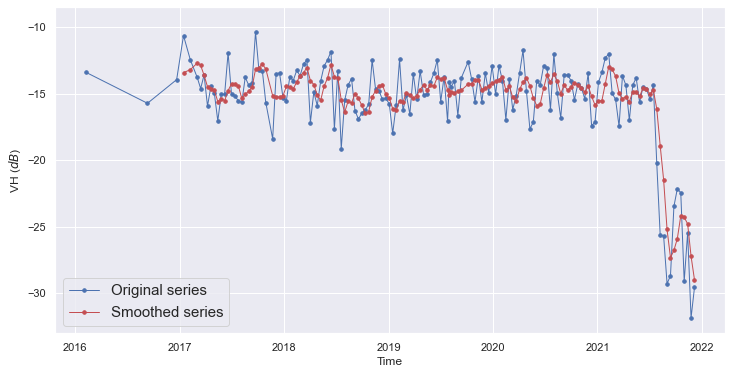

In [42]:
# graphics
fig, axes = plt.subplots(figsize = (12, 6))
axes.plot(original_ts, 'b-', marker='.', ms = 7, linewidth = 1, label = "Original series")
axes.plot(smooth_ts, 'r-', marker = '.', ms = 7, linewidth = 1, label = 'Smoothed series')
axes.set(xlabel = 'Time', ylabel = 'VH ($dB$)', ylim = (-33, -8.5))
axes.legend(fontsize = 15)
plt.show()

An extra command to see the values of the original series and the smoothed series.

In [56]:
# pandas maximum row configuration
pd.set_option('display.max_rows', 5)

# some values
print("Some values of the original time series:")
originalts.head()

Some values of the original time series:


,vh_ma_mean
date,
2016-02-06 10:14:40,-13.388868
2016-09-09 10:14:48,-15.721769
2016-12-20 10:14:03,-13.946203
2017-01-13 10:14:01,-10.637130
2017-02-06 10:14:00,-12.464820


In [57]:
# some values of the smoothed time series
print("Some values of the smoothed time series:")
smooth_ts.head()

Some values of the smoothed time series:


,vh_ma_mean
date,
2016-02-06 10:14:40,NaN
2016-09-09 10:14:48,NaN
2016-12-20 10:14:03,NaN
2017-01-13 10:14:01,-13.423492
2017-02-06 10:14:00,-13.192481


Looking for a breakpoint with the PVts-$\beta$ approach using the ```pvts``` function.

In [59]:
# Let's detect change

# using sts omiting NaN
cd = pvts(x = sts.dropna(), startm = '2021-08-20', endm = '2021-08-20', threshold = 4)

# print the result
print(f"The results of the detections:\n")
cd

The results of the detections:



{'Ts': 2017-01-13   -13.423492
 2017-02-06   -13.192481
                 ...    
 2021-11-24   -27.206137
 2021-12-06   -28.985835
 Name: vh_ma_mean, Length: 147, dtype: float64,
 'Monitoring_period': {'start': '2021-08-20', 'end': '2021-08-20'},
 'Breakpoint': {'Year_index': '2021-08-20', 'value': -21.469977025365715},
 'Threshold': {'Threshold': 4, 'Lower_limit': -17.897137534993146}}

Then, a graphic will be shown using the ```plot()``` function. Both functions come from the Python *forestools* package.

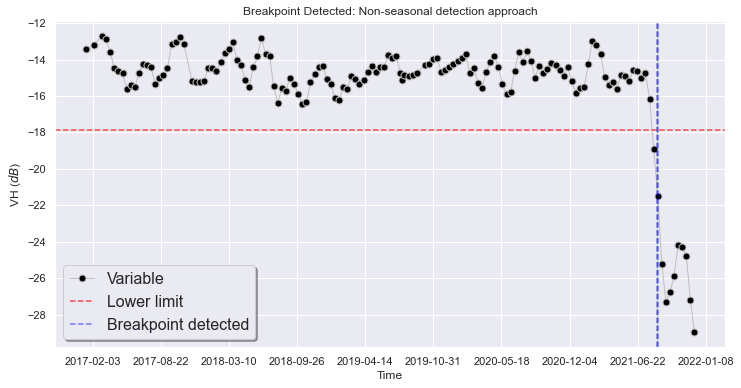

In [60]:
# plot breakpoint
plt.figure(figsize = (12,6))
plot(cd, ylabel = 'VH ($dB$)')
plt.show()

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Pros and cons about detecting deforestation in time series domain

</div>

It is important to make an analysis of the detection approaches based on time series. Using a time series analysis has advantages in certain aspects. For example, it is very likely to detect slight changes over time in photosynthetic activity than using classifications based on machine learning or deep learning ("probably"). However, a disadvantage of using time series is related to outliers, i.e. if the atmospheric noise and seasonality of the time series are not eliminated or minimized correctly, it could make any further analysis in the time series difficult. Besides, time series computation issues are currently not a major challenge due to platforms such as Earth Engine; in fact, there are time series based detection methods implemented in EE. 

On the other hand, the PVts-$\beta$ approach (based on time series) is a method that: (i) is simple and intuitive and which does not model seasonality, (ii) has only one calibration parameter to detect deforestation, and iii) can be easily implemented by any standard user. Finally, given the increased interest and activity in simple, effective, and low-cost forest monitoring methods, PVts-$\beta$ is clearly a strategic tool.

That's all!

### References

- Tarazona, Y., Mantas, V.M., Pereira, A.J.S.C. (2018). Improving tropical deforestation detection through using photosynthetic vegetation time series (PVts-β). Ecological Indicators, 94, 367 379, DOI: [10.1016/j.ecolind.2018.07.012](https://doi.org/10.1016/j.ecolind.2018.07.012)
- Tarazona, Y. (2022). Mapping deforestation using fractions indices and the PVts-beta approach, IEEE Geoscience and Remote Sensing Letters, DOI: [10.1109/LGRS.2021.3137277](https://ieeexplore.ieee.org/document/9656901).